In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
# Deshabilitamos el limite máximo de columnas mostradas en el notebook
pd.set_option('display.max_columns', None)

## Carga de datasets procesados en 'ETL.ipynb'

In [6]:
nombre_dir = 'data_pickle'

# Datasets de steam_games a pickle
df_steamgames: pd.DataFrame = pd.read_pickle(f'./{nombre_dir}/df_steamgames_clean.pkl')
df_steamgames_genres: pd.DataFrame = pd.read_pickle(f'./{nombre_dir}/df_steamgames_genres.pkl')
df_steamgames_tags: pd.DataFrame = pd.read_pickle(f'./{nombre_dir}/df_steamgames_tags.pkl')
df_steamgames_specs: pd.DataFrame = pd.read_pickle(f'./{nombre_dir}/df_steamgames_specs.pkl')

# Dataset de user_reviews a pickle
df_userreviews: pd.DataFrame = pd.read_pickle(f'./{nombre_dir}/df_userreviews_clean.pkl')

# Dataset de users_items a pickle
df_usersitems: pd.DataFrame = pd.read_pickle(f'./{nombre_dir}/df_usersitems_clean.pkl')

## Dataset: steam_games

In [35]:
df_steamgames.head()

,publisher,app_name,title,url,reviews_url,price,early_access,id,developer,release_year
88310,Kotoshiro,Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,http://steamcommunity.com/app/761140/reviews/?...,4.99,False,761140,Kotoshiro,2018-01-01
88311,"Making Fun, Inc.",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,http://steamcommunity.com/app/643980/reviews/?...,Free To Play,False,643980,Secret Level SRL,2018-01-01
88312,Poolians.com,Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,http://steamcommunity.com/app/670290/reviews/?...,Free to Play,False,670290,Poolians.com,2017-01-01
88313,彼岸领域,弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,http://steamcommunity.com/app/767400/reviews/?...,0.99,False,767400,彼岸领域,2017-01-01
88315,Trickjump Games Ltd,Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,http://steamcommunity.com/app/772540/reviews/?...,3.99,False,772540,Trickjump Games Ltd,2018-01-01


### Analisis de Precios

In [36]:
# Notamos que existen valores tipo string en 'price'
# Filtramos los strings en esta columna para visualizarlos
strings_en_col_price = df_steamgames['price'].apply(lambda x: isinstance(x, str))
df_steamgames[strings_en_col_price]['price'].value_counts()

price
Free                             668
Free to Play                     469
Free To Play                     367
Free Mod                           4
Free Demo                          3
Play for Free!                     2
Third-party                        2
Play Now                           2
Install Now                        1
Install Theme                      1
Play WARMACHINE: Tactics Demo      1
Free HITMAN™ Holiday Pack          1
Play the Demo                      1
Name: count, dtype: int64

In [37]:
# En la column 'price' existen strings que no podemos evaluar como valores numéricos
# Creamos una función que convierte los strings que sugieren ser gratuitos (contienen las palabra 'free') a valor 0.0
def convertir_gratis_a_cero(valor_en_columna):
    # Guard-clause que revisa si valor_en_columna es de tipo str
    if not isinstance(valor_en_columna, str):
        return valor_en_columna
    
    # Separamos valor_en_columna en una lista para poder evaluar su contenido
    valor_a_lista = valor_en_columna.lower().split()
    # Condicional que retorna True si valor_a_lista contiene las palabra 'free'
    es_gratuito = 'free' in valor_a_lista
    
    return 0.0 if es_gratuito else None

In [38]:
# Aplicamos 'convertir_gratis_a_cero' a columna 'price'
df_steamgames['price'] = df_steamgames['price'].apply(convertir_gratis_a_cero)
# Descartamos los valores nulos porque no podemos deducir su precio.
df_steamgames.dropna(subset=['price'], inplace=True)

In [39]:
df_steamgames['price'].describe()

count    27313.000000
mean         8.685173
std         14.644546
min          0.000000
25%          2.990000
50%          4.990000
75%          9.990000
max        995.000000
Name: price, dtype: float64

Text(0, 0.5, 'Cantidad de Juegos')

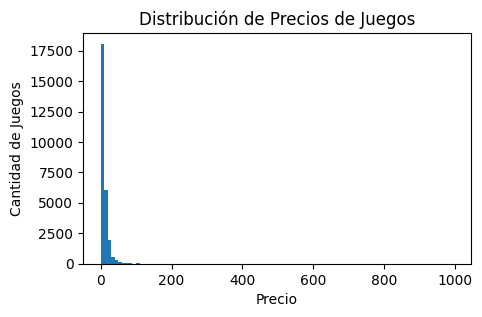

In [51]:
# Visualizamos la distribución de precios de juegos
plt.figure(figsize=(5, 3))
df_steamgames['price'].plot(kind='hist', bins=100, title='Distribución de Precios de Juegos')
plt.xlabel('Precio')
plt.ylabel('Cantidad de Juegos')

In [1]:
df_steamgames_genres.sum()

NameError: name 'df_steamgames_genres' is not defined

In [ ]:
df_steamgames_genres.info()

In [ ]:
df_steamgames_tags.head()

In [ ]:
df_steamgames_specs.head()

* **'genres'** y **'tags'** tienen información similar, con la distinción de **'tags'** ser mas detallado. Mantenemos **'genres'** intactos, y de **'tags'** restamos los tags que hacen referencia al genero, para eliminar redundancia de información.
* **'app_name'** y **'title'** tiene la misma información, y **'title'** tiende a tener valores nulos. Eliminaremos **'title'** por su redundancia..
* La información que provee **'early_access'** esta incluido en **'tags'**. Eliminaremos **'early_access'**.
* **'url'** y **'reviews_url'** no son relevantes a nuestro análisis. Se eliminaran.

## Dataset: user_reviews

In [76]:
df_userreviews.head()

,funny,posted,last_edited,item_id,helpful,recommend,review,user_id
0,,2014-06-24,NaT,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...,js41637
0,,2013-09-08,NaT,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...,js41637
0,,2013-11-29,NaT,239030,1 of 4 people (25%) found this review helpful,True,Very fun little game to play when your bored o...,js41637
1,,NaT,NaT,248820,No ratings yet,True,A suitably punishing roguelike platformer. Wi...,evcentric
1,,2015-12-04,2015-12-05,370360,No ratings yet,True,"""Run for fun? What the hell kind of fun is that?""",evcentric


* **'user_url'** no es relevante a nuestro análisis. Lo eliminaremos.

## Dataset: users_items

In [ ]:
df_usersitems.head()

* **'items_count'** y **'user_url'** no son relevantes a nuestro análisis. Los eliminaremos.
* **'user_id'** y **'steam_id'** ambos son identificadores de usuarios. El **'user_id'** en este dataset es el mismo **'user_id'** de la tabla **user_reviews**, que facilita nuestro análisis. Por esta razón, eliminaremos **'steam_id'**, por su redundancia.

In [ ]:
# for PlayTimeGenre()
df_playtime = 